##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# カスタム訓練：ウォークスルー

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">View on TensorFlow.org</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/tutorials/customization/custom_training_walkthrough.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/customization/custom_training_walkthrough.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">View source on GitHub</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/tutorials/customization/custom_training_walkthrough.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">Download notebook</a></td>
</table>

このガイドでは機械学習を使ってアヤメの花を品種によって*分類*します。TensorFlowを使って下記のことを行います。

1. モデルを構築し、
2. このモデルをサンプルデータを使って訓練し、
3. このモデルを使って未知のデータに対する予測を行う

## TensorFlow プログラミング

このガイドでは、次のような TensorFlow の高レベルの概念を用います。

- TensorFlow の既定の [Eager Execution](https://www.tensorflow.org/guide/eager) 開発環境を用いて、
- データを [Datasets API](https://www.tensorflow.org/guide/datasets) を使ってインポートし、
- TensorFlow の [Keras API](https://keras.io/getting-started/sequential-model-guide/) を使ってモデルと層を構築する

このチュートリアルは、多くの TensorFlow のプログラムと同様に下記のように構成されています。

1. データセットのインポートとパース
2. モデルのタイプの選択
3. モデルの訓練
4. モデルの有効性の評価
5. 訓練済みモデルを使った予測

## プログラムの設定

### インポートの構成

TensorFlow とその他必要な Python のモジュールをインポートします。TensorFlow は既定で [Eager Execution](https://www.tensorflow.org/guide/eager) を使って演算結果を即時に評価し、後で実行される [計算グラフ](https://www.tensorflow.org/guide/graphs) を構築する代わりに具体的な値を返します。REPL や `python` の対話的コンソールを使っている方にとっては、馴染みのあるものです。

In [2]:
import os
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf

In [4]:
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 2.0.0
Eager execution: True


## アヤメ分類問題

あなたが植物学者で、発見したアヤメの花を分類する自動的な方法を探しているとします。機械学習には花を統計的に分類するためのアルゴリズムがたくさんあります。たとえば、洗練された機械学習プログラムを使うと、写真を元に花を分類することができます。私達の願望はもう少し控えめです。アヤメの花を [sepals（萼片）](https://en.wikipedia.org/wiki/Sepal) と [petals（花弁）](https://en.wikipedia.org/wiki/Petal) の長さと幅を使って分類することにしましょう。

アヤメ属にはおよそ300の種がありますが、ここで扱うプログラムは次の3つの種類のみを分類します。

- Iris setosa
- Iris virginica
- Iris versicolor

<table>
  <tr><td>     <img src="https://www.tensorflow.org/images/iris_three_species.jpg" alt="Petal geometry compared for three iris species: Iris setosa, Iris virginica, and Iris versicolor">   </td></tr>
  <tr><td align="center">     <b>図1.</b> <a href="https://commons.wikimedia.org/w/index.php?curid=170298">Iris setosa</a> (by <a href="https://commons.wikimedia.org/wiki/User:Radomil">Radomil</a>, CC BY-SA 3.0), <a href="https://commons.wikimedia.org/w/index.php?curid=248095">Iris versicolor</a>, (by <a href="https://commons.wikimedia.org/wiki/User:Dlanglois">Dlanglois</a>, CC BY-SA 3.0), and <a href="https://www.flickr.com/photos/33397993@N05/3352169862">Iris virginica</a> (by <a href="https://www.flickr.com/photos/33397993@N05">Frank Mayfield</a>, CC BY-SA 2.0).<br>{nbsp}   </td></tr>
</table>

幸いにして、萼片と花弁の計測値を使った [120のアヤメのデータセット](https://en.wikipedia.org/wiki/Iris_flower_data_set) を作ってくれた方がいます。これは初歩の機械学習による分類問題でよく使われる古典的なデータセットです。

## 訓練用データセットのインポートとパース

データセットファイルをダウンロードし、この Python プログラムで使えるような構造に変換します。

### データセットのダウンロード

[tf.keras.utils.get_file](https://www.tensorflow.org/api_docs/python/tf/keras/utils/get_file) 関数を使って訓練用データセットをダウンロードします。この関数は、ダウンロードしたファイルのパスを返します。

In [5]:
train_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"

train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                           origin=train_dataset_url)

print("Local copy of the dataset file: {}".format(train_dataset_fp))

Local copy of the dataset file: /Users/takumi/.keras/datasets/iris_training.csv


### データの観察

このデータセット `iris_training.csv` は、表形式のデータをコンマ区切り値（CSV）形式で格納したプレインテキストファイルです。`head -n5` コマンドを使って最初の5つのエントリを見てみましょう。

In [6]:
!head -n5 {train_dataset_fp}

120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0


こうしてデータセットを見ることで次のことがわかります。

1. 最初の行はデータセットに関する情報を含むヘッダである

- 全体で120のサンプルがある。各サンプルには4つの特徴量があり、3つのラベルの1つが当てはまる。

1. 続く行はデータレコードで、1行が1つの [*サンプル(example)*](https://developers.google.com/machine-learning/glossary/#example) である。ここでは、

- 最初の4つのフィールドはサンプルの特徴を示す [*特徴量(features)*](https://developers.google.com/machine-learning/glossary/#feature) である。ここで各フィールドは花の計測値を表す浮動小数点値をもつ。
- 最後の列は予想したい [*ラベル(label)*](https://developers.google.com/machine-learning/glossary/#label) である。このデータセットでは、花の名前に対応する整数値、0、1、2 のいずれかである。

コードを書いてみましょう。

In [7]:
# CSV ファイルの列の順序
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

feature_names = column_names[:-1]
label_name = column_names[-1]

print("Features: {}".format(feature_names))
print("Label: {}".format(label_name))

Features: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
Label: species


ラベルはそれぞれ文字列の名前（たとえば、"setosa"）に関連付けられていますが、機械学習は大抵の場合、数値に依存しています。ラベルの数値は名前の表現にマップされます。たとえば次のようになります。

- `0`: Iris setosa
- `1`: Iris versicolor
- `2`: Iris virginica

特徴量とラベルについてもっと知りたい場合には、 [ML Terminology section of the Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/framing/ml-terminology) を参照してください。

In [8]:
class_names = ['Iris setosa', 'Iris versicolor', 'Iris virginica']

### `tf.data.Dataset` の作成

TensorFlow の [Dataset API](https://www.tensorflow.org/guide/datasets) はデータのモデルへのロードについて、多くの一般的なケースを扱います。この API は、データを読み込んで訓練に使われる形式へ変換するための高レベル API です。詳しくは、 [Datasets Quick Start guide](https://www.tensorflow.org/get_started/datasets_quickstart) を参照してください。

今回のデータセットは CSV 形式のテキストファイルなので、データをパースして適切なフォーマットに変換するため、 [make_csv_dataset](https://www.tensorflow.org/api_docs/python/tf/data/experimental/make_csv_dataset) 関数を使います。この関数はモデルの訓練のためのデータを生成するので、既定の動作はデータをシャッフルし (`shuffle=True, shuffle_buffer_size=10000`) 、データセットを永遠に繰り返すこと (`num_epochs=None`) です。また、 [batch_size](https://developers.google.com/machine-learning/glossary/#batch_size) パラメータも設定します。

In [9]:
batch_size = 32

train_dataset = tf.data.experimental.make_csv_dataset(
    train_dataset_fp,
    batch_size,
    column_names=column_names,
    label_name=label_name,
    num_epochs=1)

Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.


`make_csv_dataset` 関数は、 `(features, label)` というペアの `tf.data.Dataset` を返します。ここで、 `features` は、 `{'feature_name': value}` というディクショナリです。

この `Dataset` オブジェクトはイテラブルです。特徴量のバッチを1つ見てみましょう。

In [10]:
features, labels = next(iter(train_dataset))

print(features)

OrderedDict([('sepal_length', <tf.Tensor: id=68, shape=(32,), dtype=float32, numpy=
array([6.6, 4.9, 5.2, 6.4, 5. , 5. , 4.4, 4.4, 4.8, 4.7, 7.2, 6.6, 7.7,
       6.9, 7.7, 5.4, 6.4, 5.7, 6.5, 4.6, 6.9, 5.4, 5.8, 6.3, 4.5, 6.4,
       7.7, 7.7, 6.2, 5.5, 5.7, 7.4], dtype=float32)>), ('sepal_width', <tf.Tensor: id=69, shape=(32,), dtype=float32, numpy=
array([3. , 3. , 3.4, 3.2, 3.4, 3.6, 2.9, 3. , 3.4, 3.2, 3.6, 2.9, 3.8,
       3.1, 2.6, 3.7, 3.1, 2.8, 2.8, 3.4, 3.1, 3.9, 4. , 2.5, 2.3, 2.8,
       2.8, 3. , 2.8, 2.4, 3. , 2.8], dtype=float32)>), ('petal_length', <tf.Tensor: id=66, shape=(32,), dtype=float32, numpy=
array([4.4, 1.4, 1.4, 5.3, 1.6, 1.4, 1.4, 1.3, 1.6, 1.6, 6.1, 4.6, 6.7,
       5.1, 6.9, 1.5, 5.5, 4.5, 4.6, 1.4, 4.9, 1.3, 1.2, 5. , 1.3, 5.6,
       6.7, 6.1, 4.8, 3.7, 4.2, 6.1], dtype=float32)>), ('petal_width', <tf.Tensor: id=67, shape=(32,), dtype=float32, numpy=
array([1.4, 0.2, 0.2, 2.3, 0.4, 0.2, 0.2, 0.2, 0.2, 0.2, 2.5, 1.3, 2.2,
       2.3, 2.3, 0.2, 1.8, 1.3, 1

「特徴量のようなもの」はグループ化、言い換えると *バッチ化* されることに注意してください。それぞれのサンプル行のフィールドは、対応する特徴量配列に追加されます。これらの特徴量配列に保存されるサンプルの数を設定するには、 `batch_size` を変更します。

上記のバッチから特徴量のいくつかをプロットしてみると、いくつかのクラスタが見られます。

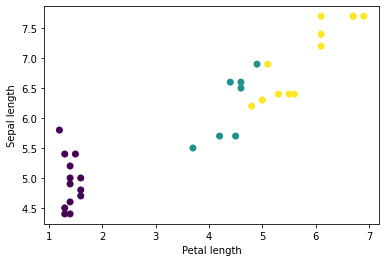

In [11]:
plt.scatter(features['petal_length'],
            features['sepal_length'],
            c=labels,
            cmap='viridis')

plt.xlabel("Petal length")
plt.ylabel("Sepal length")
plt.show()

モデル構築のステップを単純化するため、特徴量のディクショナリを `(batch_size, num_features)` という形状の単一の配列にパッケージし直す関数を作成します。

この関数は、テンソルのリストから値を受け取り、指定された次元で結合されたテンソルを作成する [tf.stack](https://www.tensorflow.org/api_docs/python/tf/stack) メソッドを使っています。

In [12]:
def pack_features_vector(features, labels):
  """特徴量を1つの配列にパックする"""
  features = tf.stack(list(features.values()), axis=1)
  return features, labels

次に、 [tf.data.Dataset.map](https://www.tensorflow.org/api_docs/python/tf/data/dataset/map) メソッドを使って `(features,label)` ペアそれぞれの `features` を訓練用データセットにパックします。

In [13]:
train_dataset = train_dataset.map(pack_features_vector)

この `Dataset` の特徴量要素は、`(batch_size, num_features)` の形状をした配列になっています。 最初のサンプルをいくつか見てみましょう。

In [14]:
features, labels = next(iter(train_dataset))

print(features[:5])

tf.Tensor(
[[4.4 3.2 1.3 0.2]
 [6.4 2.8 5.6 2.1]
 [5.4 3.7 1.5 0.2]
 [6.3 2.3 4.4 1.3]
 [4.6 3.1 1.5 0.2]], shape=(5, 4), dtype=float32)


## モデルのタイプの選択

### なぜモデルか？

[*モデル(model)*](https://developers.google.com/machine-learning/crash-course/glossary#model) は特徴量とラベルの間の関係です。アヤメの分類問題の場合、モデルは萼片と花弁の計測値と予測されるアヤメの種類の関係を定義します。単純なモデルであれば、2、3行の数式で記述できますが、複雑な機械学習モデルには多数のパラメータがあり、かんたんに要約できるものではありません。

機械学習を*使わずに*これらの4つの特徴量とアヤメの品種の関係を決定することは可能でしょうか？言い換えると、従来のプログラミング技術（たとえば、たくさんの条件文）を使ってモデルを作ることは可能でしょうか？おそらく、十分に時間をかけてデータセットを分析して、萼片と花弁の計測値と特定の品種との関係を決定すれば可能でしょう。もっと複雑なデータセットの場合には、これは困難であり、おそらく不可能です。機械学習を使ったよいアプローチでは、*あなたに代わってモデルを決定*してくれます。適切なタイプの機械学習モデルに、十分な量の典型的なサンプルを投入すれば、プログラムがあなたのためにこの関係性をみつけ出してくれるでしょう。

### モデルの選択

訓練すべきモデルの種類を決める必要があります。モデルにはたくさんの種類があり、よいものを選択するには経験が必要です。このチュートリアルでは、アヤメの分類問題を解くために、ニューラルネットワークを使用します。[*ニューラルネットワーク(Neural networks)*](https://developers.google.com/machine-learning/glossary/#neural_network) は、特徴量とラベルの間の複雑な関係をみつけることができます。ニューラルネットワークは、1つかそれ以上の [*隠れ層(hidden layers)*](https://developers.google.com/machine-learning/glossary/#hidden_layer) で構成された高度なグラフ構造です。それぞれの隠れ層には1つ以上の [*ニューロン(neurons)*](https://developers.google.com/machine-learning/glossary/#neuron) があります。ニューラルネットワークにはいくつかのカテゴリーがありますが、このプログラムでは、[*全結合ニューラルネットワーク(fully-connected neural network または dense neural network)*](https://developers.google.com/machine-learning/glossary/#fully_connected_layer) を使用します。全結合ニューラルネットワークでは、1つの層の中のニューロンすべてが、前の層の*すべての*ニューロンからの入力を受け取ります。例として、図2に入力層、2つの隠れ層、そして、出力層からなる密なニューラルネットワークを示します。

<table>
  <tr><td>     <img src="https://www.tensorflow.org/images/custom_estimators/full_network.png" alt="A diagram of the network architecture: Inputs, 2 hidden layers, and outputs">   </td></tr>
  <tr><td align="center">     <b>図2.</b> 特徴量と隠れ層、予測をもつニューラルネットワーク<br>{nbsp}   </td></tr>
</table>

図2のモデルが訓練されてラベルの付いていないサンプルを受け取ったとき、モデルは3つの予測値を返します。予測値はサンプルの花が与えられた3つの品種のそれぞれである可能性を示します。この予測は、 [*推論(inference)*](https://developers.google.com/machine-learning/crash-course/glossary#inference) とも呼ばれます。このサンプルでは、出力の予測値の合計は 1.0 になります。図2では、この予測値は *Iris setosa* が `0.02` 、 *Iris versicolor* が `0.95` 、 *Iris virginica* が `0.03` となっています。これは、モデルがこのラベルのない花を、95% の確率で *Iris versicolor* であると予測したことを意味します。

### Keras を使ったモデル構築

TensorFlow の [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras) API は、モデルと層を作成するためのおすすめの方法です。Keras がすべてを結びつけるという複雑さを引き受けてくれるため、モデルや実験の構築がかんたんになります。

[tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) モデルは層が一列に積み上げられたものです。このクラスのコンストラクタは、レイヤーインスタンスのリストを引数として受け取ります。今回の場合、それぞれ 10 のノードをもつ 2つの [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) レイヤーと、ラベルの予測値を表す3つのノードからなる出力レイヤーです。最初のレイヤーの `input_shape` パラメータがデータセットの特徴量の数に対応しており、これは必須パラメータです。

In [15]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),  # input shape required
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])

[*活性化関数(activation function)*](https://developers.google.com/machine-learning/crash-course/glossary#activation_function)  は、そのレイヤーの各ノードの出力の形を決定します。この関数の非線形性は重要であり、それがなければモデルは 1層しかないものと等価になってしまいます。[利用可能な活性化関数](https://www.tensorflow.org/api_docs/python/tf/keras/activations) はたくさんありますが、隠れ層では [ReLU](https://developers.google.com/machine-learning/crash-course/glossary#ReLU) が一般的です。

理想的な隠れ層の数やニューロンの数は問題やデータセットによって異なります。機械学習のさまざまな側面と同様に、ニューラルネットワークの最良の形を選択するには、知識と経験の両方が必要です。経験則から、一般的には隠れ層やニューロンの数を増やすとより強力なモデルを作ることができますが、効果的に訓練を行うためにより多くのデータを必要とします。

### モデルの使用

それでは、このモデルが特徴量のバッチに対して何を行うかを見てみましょう。

In [16]:
predictions = model(features)
predictions[:5]

<tf.Tensor: id=231, shape=(5, 3), dtype=float32, numpy=
array([[ 1.0866697 , -0.2931165 , -0.9713514 ],
       [-0.2961591 ,  0.47661173, -1.616561  ],
       [ 1.3219446 , -0.36931193, -1.1642225 ],
       [ 0.08943444,  0.1869154 , -1.4028213 ],
       [ 1.0494579 , -0.28473446, -1.0039386 ]], dtype=float32)>

ご覧のように、サンプルのそれぞれは、各クラスの [ロジット(logit)](https://developers.google.com/machine-learning/crash-course/glossary#logits) 値を返します。

これらのロジット値を各クラスの確率に変換するためには、 [softmax](https://developers.google.com/machine-learning/crash-course/glossary#softmax) 関数を使用します。

In [17]:
tf.nn.softmax(predictions[:5])

<tf.Tensor: id=236, shape=(5, 3), dtype=float32, numpy=
array([[0.72498506, 0.18242969, 0.09258526],
       [0.29130852, 0.630904  , 0.07778751],
       [0.7889446 , 0.14539288, 0.06566258],
       [0.42969072, 0.47368693, 0.09662233],
       [0.7185616 , 0.18924813, 0.0921903 ]], dtype=float32)>

クラス間で `tf.argmax` を取ると、予測されたクラスのインデックスが得られます。しかし、このモデルはまだ訓練されていないので、予測はよいものではありません。

In [18]:
print("Prediction: {}".format(tf.argmax(predictions, axis=1)))
print("    Labels: {}".format(labels))

Prediction: [0 1 0 1 0 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 0 0 1 0]
    Labels: [0 2 0 1 0 1 0 2 2 2 2 0 2 2 1 2 0 1 2 2 2 1 2 2 2 1 0 2 0 1 2 0]


## モデルの訓練

[*訓練(Training)*](https://developers.google.com/machine-learning/crash-course/glossary#training) は、機械学習において、モデルが徐々に最適化されていく、あるいはモデルがデータセットを*学習する*段階です。目的は、見たことのないデータについて予測を行うため、訓練用データセットの構造を十分に学習することです。訓練用データセットを学習*しすぎる*と、予測は見たことのあるデータに対してしか有効ではなく、一般化できません。この問題は [*過学習(overfitting)*](https://developers.google.com/machine-learning/crash-course/glossary#overfitting) と呼ばれ、問題の解き方を理解するのではなく答えを丸暗記するようなものです。

アヤメの分類問題は、 [*教師あり学習(supervised machine learning)*](https://developers.google.com/machine-learning/glossary/#supervised_machine_learning) の1種で、モデルはラベルの付いたサンプルを学習します。[*教師なし学習(unsupervised machine learning)*](https://developers.google.com/machine-learning/glossary/#unsupervised_machine_learning) では、サンプルにラベルはありません。そのかわり、一般的にはモデルが特徴量からパターンを発見します。

### 損失関数と勾配関数の定義

訓練段階と評価段階では、モデルの [*損失(loss)*](https://developers.google.com/machine-learning/crash-course/glossary#loss) を計算する必要があります。損失とは、モデルの予測が望ましいラベルからどれくらい離れているかを測定するものです。言い換えると、どれくらいモデルの性能が悪いかを示します。この値を最小化、または最適化したいのです。

今回のモデルでは、 `tf.keras.losses.SparseCategoricalCrossentropy` 関数を使って損失を計算します。この関数は、モデルのクラスごとの予測確率とラベルの取るべき値を使って、サンプル間の平均損失を返します。

In [19]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [20]:
def loss(model, x, y):
  y_ = model(x)

  return loss_object(y_true=y, y_pred=y_)


l = loss(model, features, labels)
print("Loss test: {}".format(l))

Loss test: 1.5603049993515015


[tf.GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape) コンテキストを使って、モデルを最適化する際に使われる [*勾配(gradients)*](https://developers.google.com/machine-learning/crash-course/glossary#gradient) を計算しましょう。

In [21]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

### オプティマイザの作成

[*オプティマイザ(optimizer)*](https://developers.google.com/machine-learning/crash-course/glossary#optimizer) は、`loss` 関数を最小化するため、計算された勾配をモデルの変数に適用します。損失関数は、曲面として考えることができ（図3 参照）、歩き回ることによって最小となる点をみつけたいのです。勾配は、一番急な上りの方向を示すため、逆方向に進んで丘を下ることになります。バッチごとに損失と勾配を繰り返し計算することにより、訓練中のモデルを調節します。モデルは徐々に、損失を最小化する重みとバイアスの最適な組み合わせをみつけます。損失が小さいほど、モデルの予測がよくなります。

<table>
  <tr><td>     <img src="https://cs231n.github.io/assets/nn3/opt1.gif" width="70%" alt="Optimization algorithms visualized over time in 3D space.">   </td></tr>
  <tr><td align="center">     <b>図3.</b> 3次元空間における最適化アルゴリズムの時系列可視化。<br>(Source: <a href="http://cs231n.github.io/neural-networks-3/">Stanford class CS231n</a>, MIT License, Image credit: <a href="https://twitter.com/alecrad">Alec Radford</a>)   </td></tr>
</table>

TensorFlow には、訓練に使える [最適化アルゴリズム(optimization algorithms)](https://www.tensorflow.org/api_guides/python/train) がたくさんあります。このモデルでは、[*確率的勾配降下法(stochastic gradient descent)*](https://developers.google.com/machine-learning/crash-course/glossary#gradient_descent) (SGD) アルゴリズムを実装した [tf.train.GradientDescentOptimizer](https://www.tensorflow.org/api_docs/python/tf/train/GradientDescentOptimizer) を使用します。`learning_rate` （学習率）は、イテレーションごとに丘を下る際のステップのサイズを設定します。通常これはよりよい結果を得るために調整する *ハイパーパラメータ(hyperparameter)* です。

オプティマイザーを設定しましょう。

In [22]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

これを使って、最適化を１ステップ分計算してみます。

In [23]:
loss_value, grads = grad(model, features, labels)

print("Step: {}, Initial Loss: {}".format(optimizer.iterations.numpy(),
                                          loss_value.numpy()))

optimizer.apply_gradients(zip(grads, model.trainable_variables))

print("Step: {},         Loss: {}".format(optimizer.iterations.numpy(),
                                          loss(model, features, labels).numpy()))

Step: 0, Initial Loss: 1.5603049993515015
Step: 1,         Loss: 1.0321049690246582


### 訓練ループ

すべての部品が揃ったので、モデルの訓練ができるようになりました。訓練ループは、モデルにデータセットのサンプルを供給し、モデルがよりよい予測を行えるようにします。下記のコードブロックは、この訓練のステップを構成します。

1. *epoch（エポック）* をひとつずつ繰り返します。エポックとは、データセットをひととおり処理するということです。
2. エポック内では、訓練用の `Dataset（データセット）` のサンプルひとつずつから、その *features（特徴量）* (`x`) と *label（ラベル）* (`y`) を取り出して繰り返し処理します。
3. サンプルの特徴量を使って予測を行い、ラベルと比較します。予測の不正確度を測定し、それを使ってモデルの損失と勾配を計算します。
4. `optimizer` を使って、モデルの変数を更新します。
5. 可視化のためにいくつかの統計量を記録します。
6. これをエポックごとに繰り返します。

`num_epochs` 変数は、データセットのコレクションを何回繰り返すかという数字です。直感には反しますが、モデルを長く訓練すれば必ずよいモデルが得られるというわけではありません。`num_epochs` は、[*ハイパーパラメータ(hyperparameter)*](https://developers.google.com/machine-learning/glossary/#hyperparameter) であり、チューニングできます。適切な数を選択するには、経験と実験の両方が必要です。

In [24]:
## Note: このセルを再実行すると同じモデル変数が使われます

# 結果をグラフ化のために保存
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

  # 訓練ループ - 32個ずつのバッチを使用
  for x, y in train_dataset:
    # モデルの最適化
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # 進捗の記録
    epoch_loss_avg(loss_value)  # Add current batch loss 現在のバッチの損失を加算
    # 予測ラベルと実際のラベルを比較
    epoch_accuracy(y, model(x))
    
  # エポックの終わり
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

Epoch 000: Loss: 0.868, Accuracy: 69.167%
Epoch 050: Loss: 0.083, Accuracy: 97.500%
Epoch 100: Loss: 0.058, Accuracy: 99.167%
Epoch 150: Loss: 0.052, Accuracy: 99.167%
Epoch 200: Loss: 0.058, Accuracy: 97.500%


### 時間の経過に対する損失関数の可視化

モデルの訓練の進み方をプリントするのも役立ちますが、普通はこの進捗を見るほうが*もっと*役に立ちます。[TensorBoard](https://www.tensorflow.org/guide/summaries_and_tensorboard) は TensorFlow に付属する優れた可視化ツールですが、 `matplotlib` モジュールを使って基本的なグラフを描画することもできます。

これらのグラフを解釈するにはある程度の経験が必要ですが、*損失*が低下して、*正解率*が上昇するのをぜひ見たいと思うでしょう。

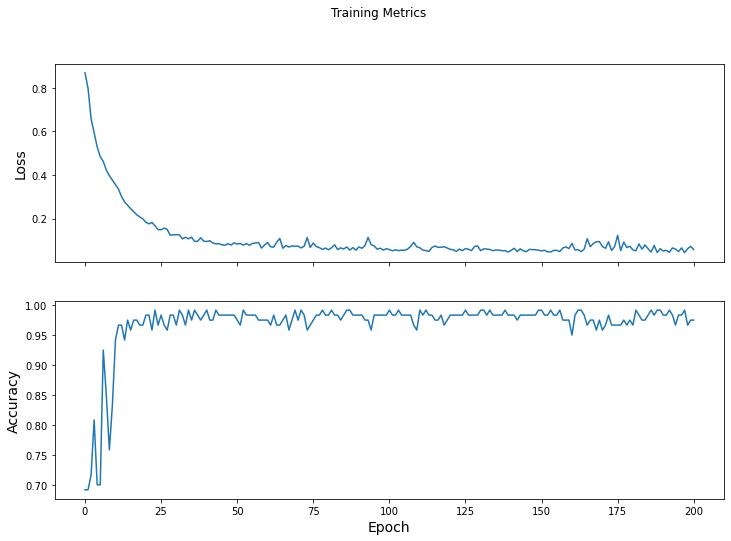

In [25]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

## モデルの有効性評価

モデルの訓練が終わったら、その性能の指標を得ることができます。

*評価*とは、モデルの予測がどれだけ効果的であるかどうかを決定することを言います。アヤメの分類でモデルの有効性を見定めるには、モデルに萼片と花弁の測定値をいくつか与え、どのアヤメの品種であるかを予測させます。そして、モデルの予測と実際のラベルを比較します。たとえば、あるモデルが入力サンプルの半分で正解の品種をえらんだとすると、[*正解率(accuracy)*](https://developers.google.com/machine-learning/glossary/#accuracy) は `0.5` ということになります。図４で示すモデルはもう少し効果的であり、5つの予測中4つで正解し、正解率は 80% です。

<table cellpadding="8" border="0">
  <colgroup>
    <col span="4">
    <col span="1" bgcolor="lightblue">
    <col span="1" bgcolor="lightgreen">
  </colgroup>
  <tr bgcolor="lightgray">
    <th colspan="4">サンプルの特徴量</th>
    <th colspan="1">ラベル</th>
    <th colspan="1">モデルの予測値</th>
  </tr>
  <tr>
    <td>5.9</td>
<td>3.0</td>
<td>4.3</td>
<td>1.5</td>
<td align="center">1</td>
<td align="center">1</td>
  </tr>
  <tr>
    <td>6.9</td>
<td>3.1</td>
<td>5.4</td>
<td>2.1</td>
<td align="center">2</td>
<td align="center">2</td>
  </tr>
  <tr>
    <td>5.1</td>
<td>3.3</td>
<td>1.7</td>
<td>0.5</td>
<td align="center">0</td>
<td align="center">0</td>
  </tr>
  <tr>
    <td>6.0</td> <td>3.4</td> <td>4.5</td> <td>1.6</td> <td align="center">1</td>
<td align="center" bgcolor="red">2</td>
  </tr>
  <tr>
    <td>5.5</td>
<td>2.5</td>
<td>4.0</td>
<td>1.3</td>
<td align="center">1</td>
<td align="center">1</td>
  </tr>
  <tr><td align="center" colspan="6">     <b>図4.</b> 正解率 80％ のアヤメ分類器<br>{nbsp}   </td></tr>
</table>

### テスト用データセットの設定

モデルの評価はモデルの訓練と同様です。もっとも大きな違いは、サンプルが訓練用データセットではなく[*テスト用データセット(test set)*](https://developers.google.com/machine-learning/crash-course/glossary#test_set) からのものであるという点です。モデルの有効性を正しく評価するには、モデルの評価に使うサンプルは訓練用データセットのものとは違うものでなければなりません。

テスト用 `Dataset` の設定は、訓練用 `Dataset` の設定と同様です。CSV ファイルをダウンロードし、値をパースしてからすこしシャッフルを行います。

In [26]:
test_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv"

test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url),
                                  origin=test_url)

8192/573 [============================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 0us/step


In [27]:
test_dataset = tf.data.experimental.make_csv_dataset(
    test_fp,
    batch_size,
    column_names=column_names,
    label_name='species',
    num_epochs=1,
    shuffle=False)

test_dataset = test_dataset.map(pack_features_vector)

### テスト用データセットでのモデルの評価

訓練段階とは異なり、モデルはテスト用データの 1[エポック(epoch)](https://developers.google.com/machine-learning/glossary/#epoch) だけで行います。下記のコードセルでは、テスト用データセットのサンプルをひとつずつ処理し、モデルの予測と実際のラベルを比較します。この結果を使ってテスト用データセット全体でのモデルの正解率を計算します。

In [28]:
test_accuracy = tf.keras.metrics.Accuracy()

for (x, y) in test_dataset:
  logits = model(x)
  prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
  test_accuracy(prediction, y)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 96.667%


たとえば最後のバッチを見ると、モデルはだいたい正確です。

In [29]:
tf.stack([y,prediction],axis=1)

<tf.Tensor: id=113051, shape=(30, 2), dtype=int32, numpy=
array([[1, 1],
       [2, 2],
       [0, 0],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 0],
       [2, 1],
       [1, 1],
       [2, 2],
       [2, 2],
       [0, 0],
       [2, 2],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [2, 2],
       [0, 0],
       [1, 1],
       [2, 2],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [2, 2],
       [1, 1]], dtype=int32)>

## 訓練済みモデルを使った予測

モデルを訓練し、それが、完全ではないにせよアヤメの品種の分類でよい性能を示すことを「証明」しました。次は、この訓練済みモデルを使って [ラベルなしサンプル(unlabeled examples)](https://developers.google.com/machine-learning/glossary/#unlabeled_example) つまり、特徴量だけでラベルのないサンプルについて予測を行ってみましょう。

現実世界では、ラベルなしサンプルはアプリや CSV ファイル、データフィードなどさまざまな異なるソースからやってきます。ここでは、ラベルを予測するため、3つのラベルなしサンプルを手動で与えることにします。ラベルの番号は、下記のように名前を表していることを思い出してください。

- `0`: Iris setosa
- `1`: Iris versicolor
- `2`: Iris virginica

In [30]:
predict_dataset = tf.convert_to_tensor([
    [5.1, 3.3, 1.7, 0.5,],
    [5.9, 3.0, 4.2, 1.5,],
    [6.9, 3.1, 5.4, 2.1]
])

predictions = model(predict_dataset)

for i, logits in enumerate(predictions):
  class_idx = tf.argmax(logits).numpy()
  p = tf.nn.softmax(logits)[class_idx]
  name = class_names[class_idx]
  print("Example {} prediction: {} ({:4.1f}%)".format(i, name, 100*p))

Example 0 prediction: Iris setosa (99.9%)
Example 1 prediction: Iris versicolor (99.9%)
Example 2 prediction: Iris virginica (95.3%)
